In [13]:
from IPython.display import HTML

HTML("""
<style>
/* Hide code cells by default */
div.input, div.jp-InputArea {
    display: none;
}
</style>

<button id="toggleCode" style="
    background:#0A4A7A;
    color:white;
    border:none;
    padding:8px 14px;
    font-size:14px;
    border-radius:6px;
    cursor:pointer;
    margin-bottom:12px;
">
Show / Hide Code
</button>

<script>
let visible = false;
document.getElementById("toggleCode").onclick = function () {
    visible = !visible;
    document.querySelectorAll('div.input, div.jp-InputArea').forEach(el => {
        el.style.display = visible ? 'block' : 'none';
    });
};
</script>
""")


 # <span style="color:#9467bd"><b>📊 BUSINESS DATA CASE </b></span>


In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

## <span style="color:#1f77b4"><b>STEP 1: Customers’ insights discovery</b></span>


### <span style="color:#1f77b4"><b>Retailer Dataset: Data Cleaning and Descriptive Statistics </b></span> 

In [3]:
df_retailer = pd.read_csv('data/retailer.csv')
df_retailer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9866049 entries, 0 to 9866048
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   customer_id    object 
 1   timestamp_utc  object 
 2   event_name     object 
 3   brand          object 
 4   product_name   object 
 5   sales          float64
 6   quantity       float64
dtypes: float64(2), object(5)
memory usage: 526.9+ MB


The dataset contains **7 variables** and **9,866,049 rows (events)**.  
The variable `timestamp_utc` is stored as an object (string).  
Therefore, it needs to be converted into a proper **date/datetime variable** to enable time-based analysis.


In [4]:
df_retailer.head(10)

,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
0,reFs5GI87lXJkJSi9r,2024-02-07 02:27:10,Product Page View,NaN,NaN,NaN,NaN
1,reFs5GI87lXJkJSi9r,2024-06-12 16:16:54,Product Page View,Science Diet,SD Fel A7+ SavCknEnt 24x5.5oz cs,NaN,NaN
2,reTjziox2cSrxVq70Y,2024-02-28 04:11:46,Product Page View,NaN,NaN,NaN,NaN
3,reTjziox2cSrxVq70Y,2024-02-28 04:30:42,Product Page View,Science Diet,SD Fel Adt HBC OFEnt 24x5.5oz cs,NaN,NaN
4,reOrpt9vhSwhbPVtni,2024-06-01 22:22:30,Product Page View,NaN,NaN,NaN,NaN
5,reOrpt9vhSwhbPVtni,2024-06-01 22:36:26,Product Page View,Science Diet,SD Ca Adt Lt Ckn 30lb bg,NaN,NaN
6,reOrpt9vhSwhbPVtni,2024-06-01 22:43:07,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
7,reOrpt9vhSwhbPVtni,2024-06-20 14:02:48,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
8,reOrpt9vhSwhbPVtni,2024-06-06 10:38:51,Order,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,19.99,1.0
9,reOrpt9vhSwhbPVtni,2024-06-01 22:47:09,Add to cart,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN


In [4]:
col1 = ['event_name', 'brand']

for c in col1:
    print(f"\n=== {c} ===")
    print(df_retailer[c].unique())


=== event_name ===
['Product Page View' 'Order' 'Add to cart']

=== brand ===
[nan 'Science Diet' 'Hills' 'Prescription Diet']


In [7]:
summary_stats = (
    df_retailer
    .describe()
    .T
    .assign(missing=df_retailer.isna().sum())
)

summary_stats


,count,mean,std,min,25%,50%,75%,max,missing
sales,1439311.0,43.373495,27.617822,0.0,22.48,41.87,55.99,1184.7,8426738
quantity,1439311.0,1.081074,0.403381,0.0,1.00,1.00,1.00,30.0,8426738


In [8]:
categorical_summary = df_retailer.select_dtypes(include='object').describe().T
categorical_summary

,count,unique,top,freq
customer_id,9866049,1354584,unknown,194530
timestamp_utc,9866049,6920394,2024-01-12 16:18:17,10
event_name,9866049,3,Product Page View,6376627
brand,9588809,3,Science Diet,7858536
product_name,9588809,505,SD Ca Adt SmPws Ckn 4.5lb bg,221043


#### <span style="color:#a51c30"><b>How should we handle `unknown` customer_id values?</b></span>


In [ ]:
df_freq_clients = df_retailer['customer_id'].value_counts().reset_index()
df_freq_clients.columns = ['customer_id', 'frequency']
df_freq_clients

The value **`unknown`** appears as a specific customer identifier and aggregates a large number of events.  
These observations correspond to interactions and purchases for which **no individual customer ID is available**.

For analyses that do **not rely on customer-level identification**—such as overall event distributions, brand performance, or funnel-level statistics—these observations are **kept**, as they still contribute valid behavioral information.

However, for analyses that explicitly depend on customer identity—including **average basket size**, **average purchase value**, **purchase frequency**, **customer segmentation**, or **joins with other customer-level tables**—the observations associated with `unknown` are **excluded** to avoid bias and ensure consistency.


#### <span style="color:#a51c30"><b>Should we keep rows where `brand` and `product_name` are NaN?</b></span>


In [9]:
df_to_check = df_retailer[
    df_retailer[['brand', 'product_name']].isna().all(axis=1)
]
df_to_check.shape

(277240, 7)

There are **277,240 rows** where both `brand` and `product_name` are missing.  
To decide whether these rows should be kept or removed, we check **whether any purchases occurred in these rows**.

If no purchase events (`Order`) are associated with these observations, they do not contribute to revenue or conversion analysis and can be safely removed.  
Otherwise, they would require further investigation.

In [10]:
df_sales_notna = df_to_check[df_retailer['sales'].notna()]
df_sales_notna.shape

C:\Users\nouts\AppData\Local\Temp\ipykernel_18484\539845987.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sales_notna = df_to_check[df_retailer['sales'].notna()]


(8776, 7)

In [11]:
df_sales_notna.head()

,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
863,reczbO5sThS4rw0JdJ,2024-01-05 21:38:18,Order,NaN,NaN,78.99,1.0
885,reSFq86EE91VCfBImt,2024-03-15 03:35:17,Order,NaN,NaN,101.55,1.0
1575,reOseksZcmsUreRQbs,2024-03-15 02:40:17,Order,NaN,NaN,101.55,1.0
3608,re3Brfqpz42LjIx8Vc,2024-05-11 20:33:39,Order,NaN,NaN,96.99,1.0
5404,reLJUcuTVC8k9FQsNK,2024-04-14 03:19:34,Order,NaN,NaN,37.85,1.0


Among these rows, **more than 8,000 observations correspond to purchase events (`Order`)**.  
This indicates that some transactions occurred even when `brand` and `product_name` were missing.

In [12]:
# Filter for rows with NaN in brand, product_name, sales, AND event_name
df_check_all_nan = df_retailer[
    (df_retailer[['brand', 'product_name', 'sales']].isna().all(axis=1)) &
    (df_retailer['event_name'].isna())
]

df_check_all_nan.shape

(0, 7)

In the end, although no information is available on `brand` and `product_name`, we know that the individuals concerned **at least visited a product page**, and that **some of these observations correspond to actual purchases**.

Therefore, these rows still carry relevant behavioral and transactional information.  
For now, they are **kept in the dataset**, and this issue will be **revisited later** if more detailed product-level analysis is required.


#### <span style="color:#1f77b4"><b>Brands and Events distribution</b></span> 

In [5]:
# Convert the timestamp column to datetime format and extract the date component
df_retailer['timestamp_utc'] = pd.to_datetime(df_retailer['timestamp_utc'])
df_retailer['date'] = df_retailer['timestamp_utc'].dt.date

In [6]:
# Key descriptive statistics
infos = {
    "n_events": len(df_retailer),
    "n_customers": df_retailer["customer_id"].nunique(),
    "n_products": df_retailer["product_name"].nunique(),
    "n_brands": df_retailer["brand"].value_counts().to_dict(),
    "event_distribution": df_retailer["event_name"].value_counts().to_dict()
}

infos

{'n_events': 9866049,
 'n_customers': 1354584,
 'n_products': 505,
 'n_brands': {'Science Diet': 7858536,
  'Prescription Diet': 1247520,
  'Hills': 482753},
 'event_distribution': {'Product Page View': 6376627,
  'Add to cart': 2050111,
  'Order': 1439311}}

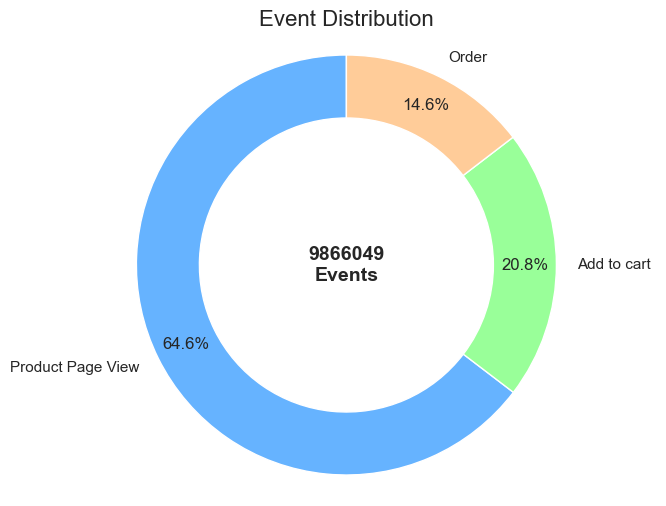

In [7]:
data = infos["event_distribution"]
labels = list(data.keys())
sizes = list(data.values())
total_events = sum(sizes)

plt.figure(figsize=(8, 6))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,
        colors=['#66b3ff','#99ff99','#ffcc99'], 
        wedgeprops=dict(width=0.3, edgecolor='white'))

plt.text(0, 0, f"{total_events}\nEvents", 
         ha='center', va='center', fontsize=14, fontweight='bold')

plt.title("Event Distribution", fontsize=16)
plt.axis('equal') 
plt.show()

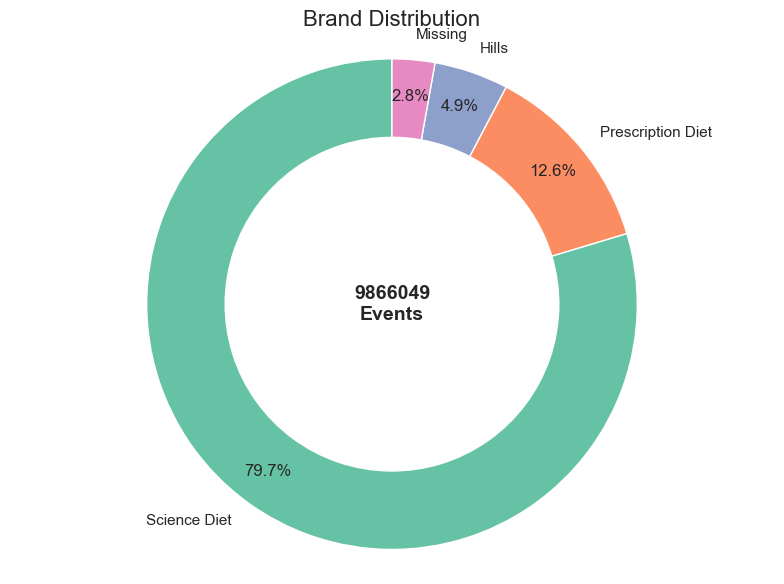

In [8]:
brand_counts = df_retailer["brand"].fillna("Missing").value_counts()
labels = brand_counts.index
sizes = brand_counts.values
total_events = df_retailer.shape[0]

plt.figure(figsize=(8, 6))

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,
        colors=colors[:len(labels)], 
        wedgeprops=dict(width=0.32, edgecolor='white'))

plt.text(0, 0, f"{total_events}\nEvents", 
         ha='center', va='center', fontsize=14, fontweight='bold')

plt.title("Brand Distribution", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

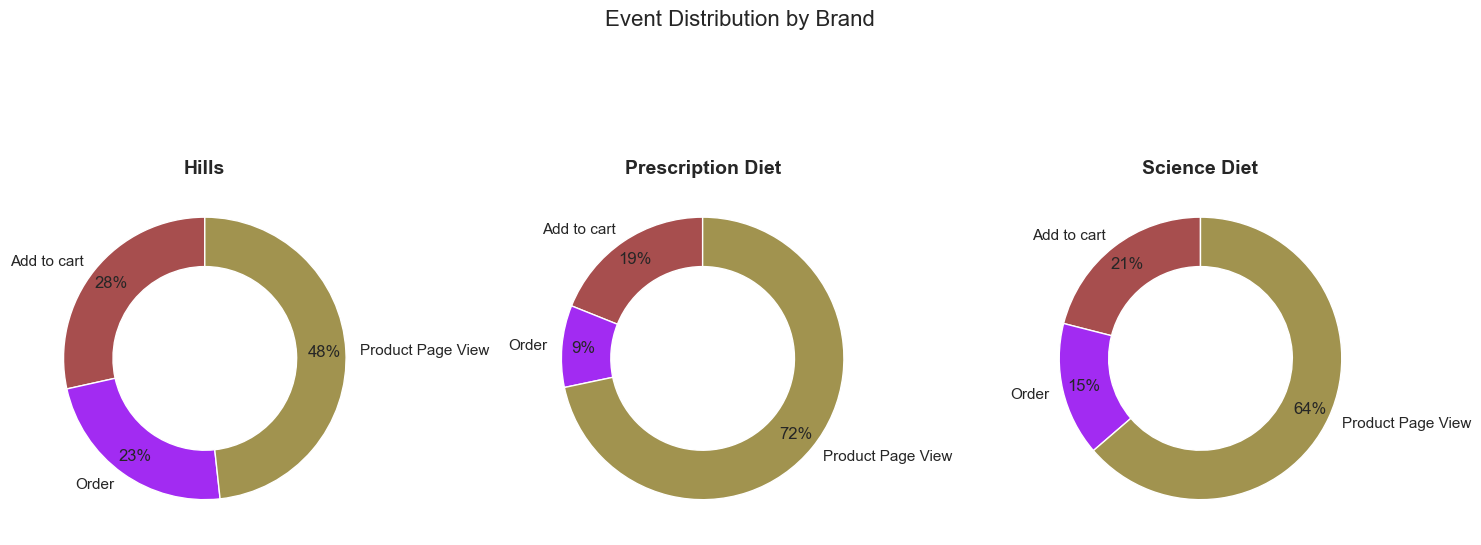

In [9]:
event_brand = (
    df_retailer
    .groupby(["brand", "event_name"])
    .size()
    .reset_index(name="freq")
)
event_brand["brand"] = event_brand["brand"].fillna("Missing")

brands = event_brand["brand"].unique()
events = event_brand["event_name"].unique()

custom_colors = ["#A74E4E", "#A22BF2", "#A1934F"]
if len(events) > len(custom_colors):
    color_map = dict(zip(events, sns.color_palette("Set2", len(events))))
else:
    color_map = dict(zip(events, custom_colors))

fig, axes = plt.subplots(1, len(brands), figsize=(5 * len(brands), 6))

if len(brands) == 1:
    axes = [axes]

for ax, brand in zip(axes, brands):
    subset = event_brand[event_brand["brand"] == brand]
    
    subset_colors = [color_map[e] for e in subset["event_name"]]
    
    ax.pie(subset['freq'], labels=subset['event_name'], autopct='%1.0f%%', 
           startangle=90, pctdistance=0.85, colors=subset_colors,
           wedgeprops=dict(width=0.35, edgecolor='white')) 
    
    ax.set_title(brand, fontsize=14, fontweight='bold')

plt.suptitle("Event Distribution by Brand", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

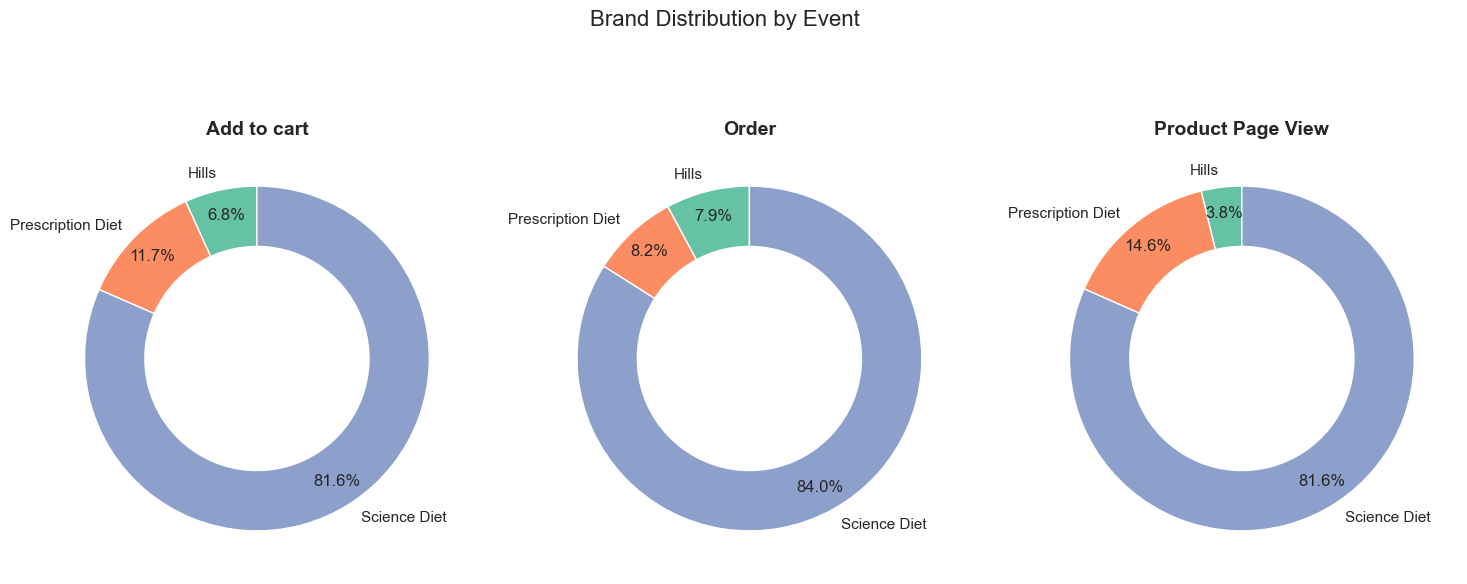

In [10]:
brand_event = (
    df_retailer
    .groupby(["event_name", "brand"])
    .size()
    .reset_index(name="freq")
)
brand_event["brand"] = brand_event["brand"].fillna("Missing")

events = brand_event["event_name"].unique()
brands = brand_event["brand"].unique()

palette = sns.color_palette("Set2", len(brands))
color_map = dict(zip(brands, palette))

fig, axes = plt.subplots(1, len(events), figsize=(5 * len(events), 6))

if len(events) == 1:
    axes = [axes]

for ax, event in zip(axes, events):
    subset = brand_event[brand_event["event_name"] == event]
    
    subset_colors = [color_map[b] for b in subset["brand"]]
    
    ax.pie(subset['freq'], labels=subset['brand'], autopct='%1.1f%%', 
           startangle=90, pctdistance=0.85, colors=subset_colors,
           wedgeprops=dict(width=0.35, edgecolor='white'))
    
    ax.set_title(event, fontsize=14, fontweight='bold')

plt.suptitle("Brand Distribution by Event", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

**Product Page View** events represent the largest share of all events, followed by **Add to cart** and **Order** events.  
**Science Diet** accounts for the majority of events across all event types, while **Prescription Diet** and **Hills** contribute smaller proportions.  

The distribution of brands is **consistent across event types**, with Science Diet remaining dominant at each stage of the funnel.  
When analyzing events by brand, **Hills shows a higher proportion of Order events** relative to its total volume, whereas **Prescription Diet exhibits a lower proportion of Orders**.  
**Science Diet** displays a higher share of Product Page View events compared to Order events.


#### <span style="color:#1f77b4"><b>Brand-Level Revenue and Sales Volume</b></span> 


/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/466346630.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/466346630.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


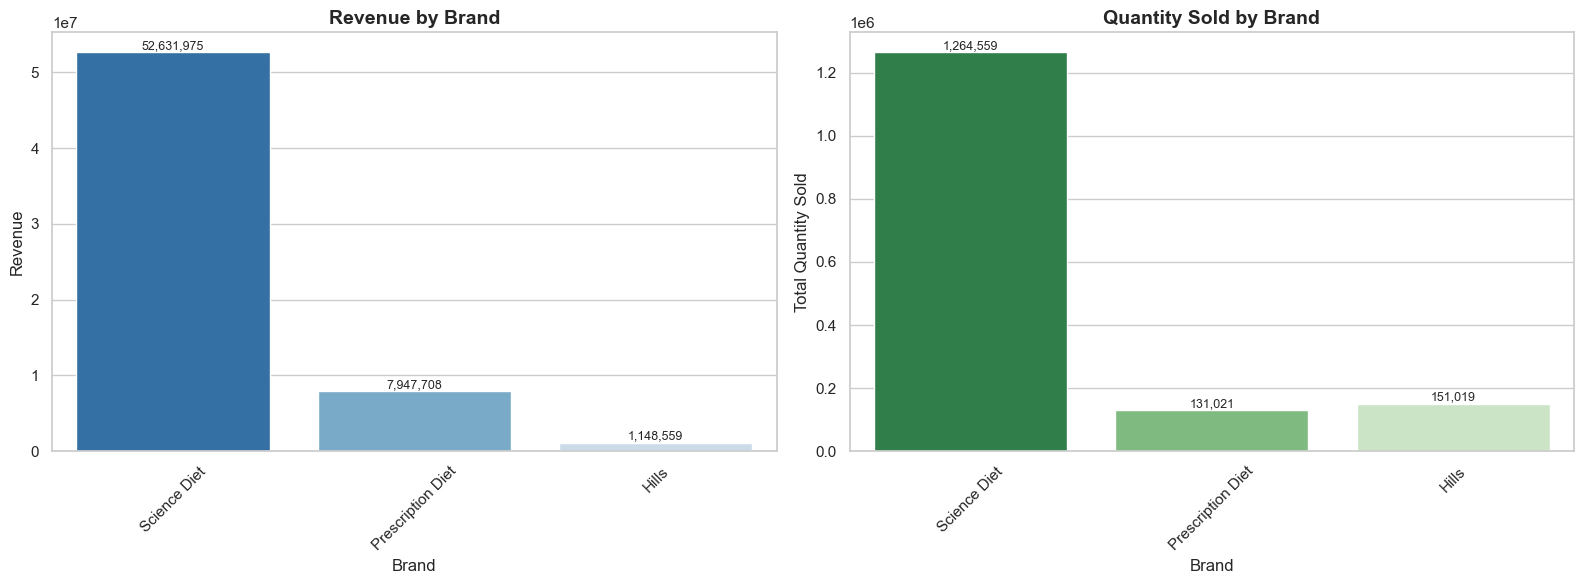

In [11]:
# Revenue and quantity sold by brand
sns.set_theme(style="whitegrid")

# Aggregate data
brand_metrics = (
    df_retailer
    .groupby('brand')
    .agg(
        revenue=('sales', 'sum'),
        quantity=('quantity', 'sum')
    )
    .reset_index()
    .sort_values('revenue', ascending=False)
)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# --- Revenue ---
sns.barplot(
    data=brand_metrics,
    x='brand',
    y='revenue',
    palette='Blues_r',
    ax=axes[0]
)
axes[0].set_title("Revenue by Brand", fontsize=14, weight='bold')
axes[0].set_xlabel("Brand")
axes[0].set_ylabel("Revenue")
axes[0].tick_params(axis='x', rotation=45)

# Add labels
for i, v in enumerate(brand_metrics['revenue']):
    axes[0].text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=9)

# --- Quantity ---
sns.barplot(
    data=brand_metrics,
    x='brand',
    y='quantity',
    palette='Greens_r',
    ax=axes[1]
)
axes[1].set_title("Quantity Sold by Brand", fontsize=14, weight='bold')
axes[1].set_xlabel("Brand")
axes[1].set_ylabel("Total Quantity Sold")
axes[1].tick_params(axis='x', rotation=45)

# Add labels
for i, v in enumerate(brand_metrics['quantity']):
    axes[1].text(i, v, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Science Diet dominates both revenue and quantity sold. It generates approximately **52.6 million** in revenue and sells about **1.26 million units**, far exceeding the other brands. Prescription Diet records around **7.9 million** in revenue with approximately **131 thousand units sold**, while Hills shows the lowest revenue at about **1.15 million**, despite selling around **151 thousand units**, which is slightly higher than Prescription Diet in volume. This indicates that Prescription Diet generates higher revenue than Hills with fewer units sold, whereas Hills sells more units but generates less revenue.


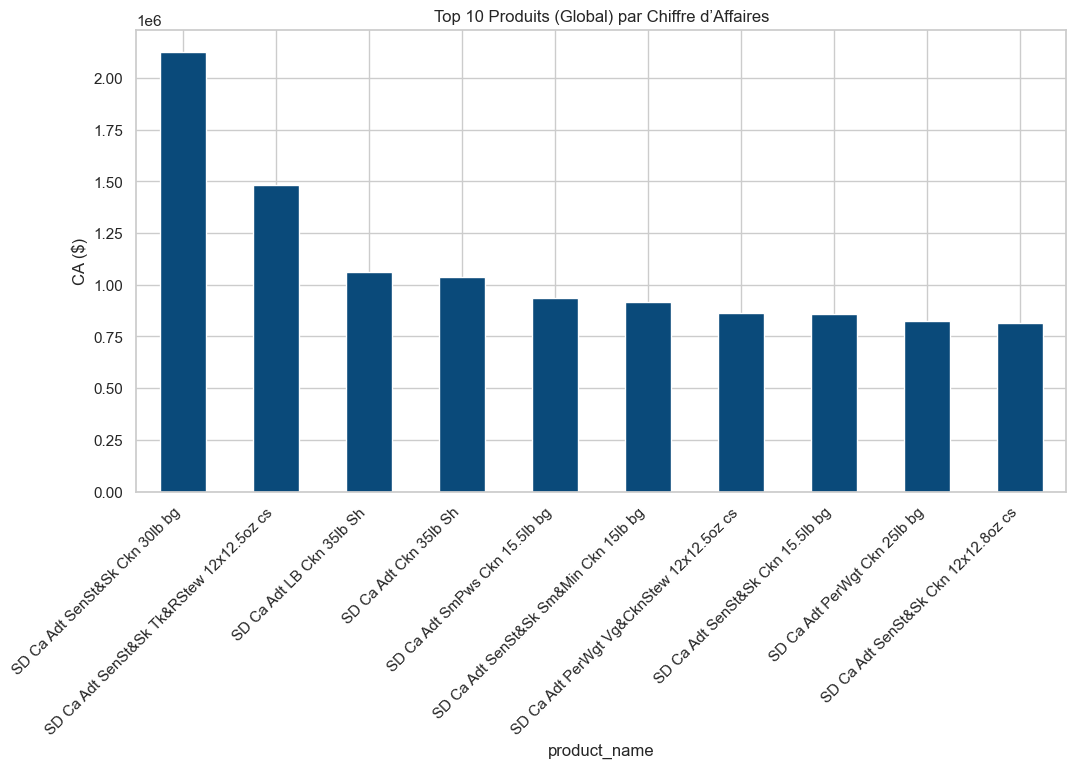

Focus sur la marque leader : Science Diet


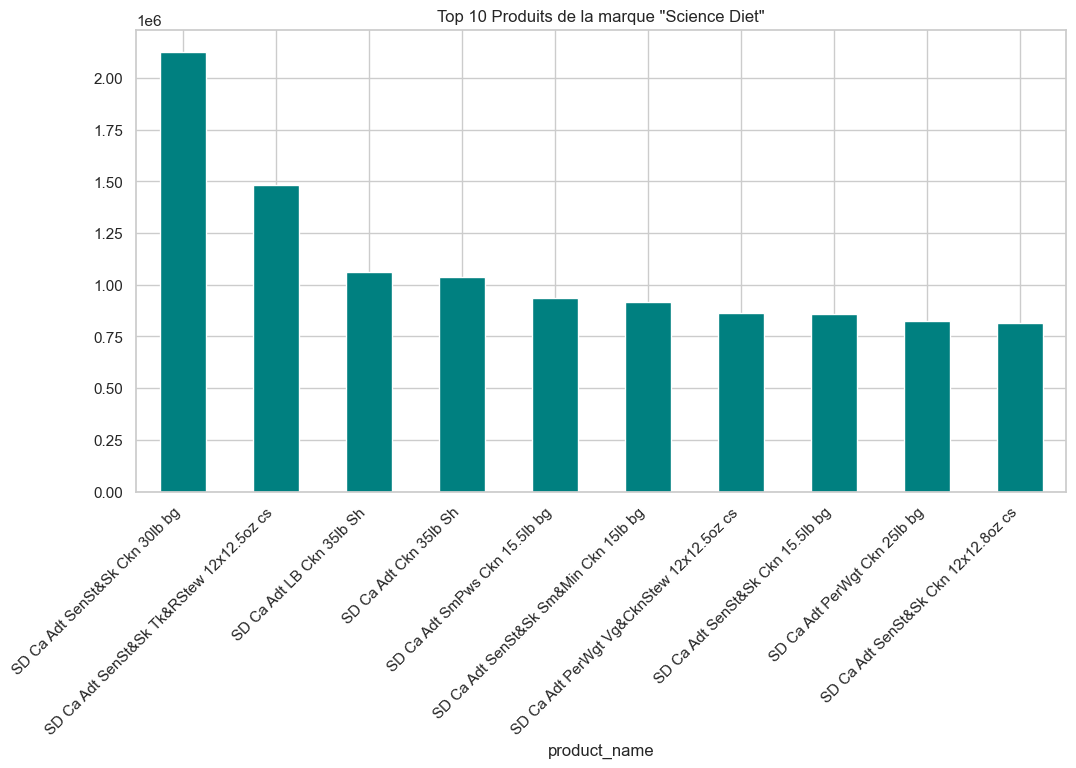

In [12]:
df_orders_temp = df_retailer[df_retailer['event_name'] == 'Order']

# 1. Top 10 Produits Global
top10_products = df_orders_temp.groupby('product_name')['sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top10_products.plot(kind='bar', color='#0A4A7A')
plt.title('Top 10 Produits (Global) par Chiffre d’Affaires')
plt.ylabel('CA ($)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Top Produits de la Marque Leader
marque_leader = df_orders_temp.groupby('brand')['sales'].sum().idxmax()
print(f"Focus sur la marque leader : {marque_leader}")

df_leader = df_orders_temp[df_orders_temp['brand'] == marque_leader]
top10_leader = df_leader.groupby('product_name')['sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top10_leader.plot(kind='bar', color='teal')
plt.title(f'Top 10 Produits de la marque "{marque_leader}"')
plt.xticks(rotation=45, ha='right')
plt.show()

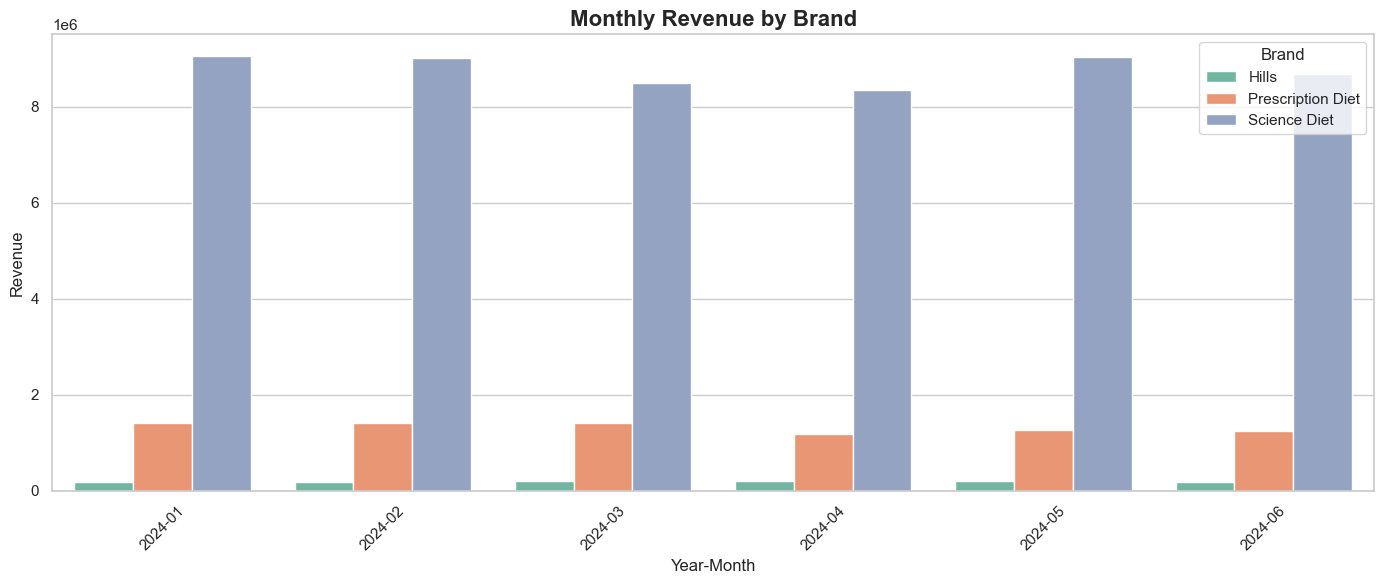

In [13]:
# Monthly revenue by brand
sns.set_theme(style="whitegrid")

# Ensure date column is datetime
df_retailer['date'] = pd.to_datetime(df_retailer['date'], errors='coerce')

# Keep only valid sales
df_sales = df_retailer[df_retailer['sales'].notna()].copy()

# Create year-month column
df_sales['year_month'] = df_sales['date'].dt.to_period('M').astype(str)

# Monthly revenue per brand
monthly_revenue = (
    df_sales.groupby(['year_month', 'brand'])['sales']
    .sum()
    .reset_index()
)

# Grouped bar chart
plt.figure(figsize=(14,6))

sns.barplot(
    data=monthly_revenue,
    x='year_month',
    y='sales',
    hue='brand',
    palette='Set2'
)

plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.title("Monthly Revenue by Brand", fontsize=16, weight="bold")
plt.xticks(rotation=45)
plt.legend(title="Brand")
plt.tight_layout()
plt.show()


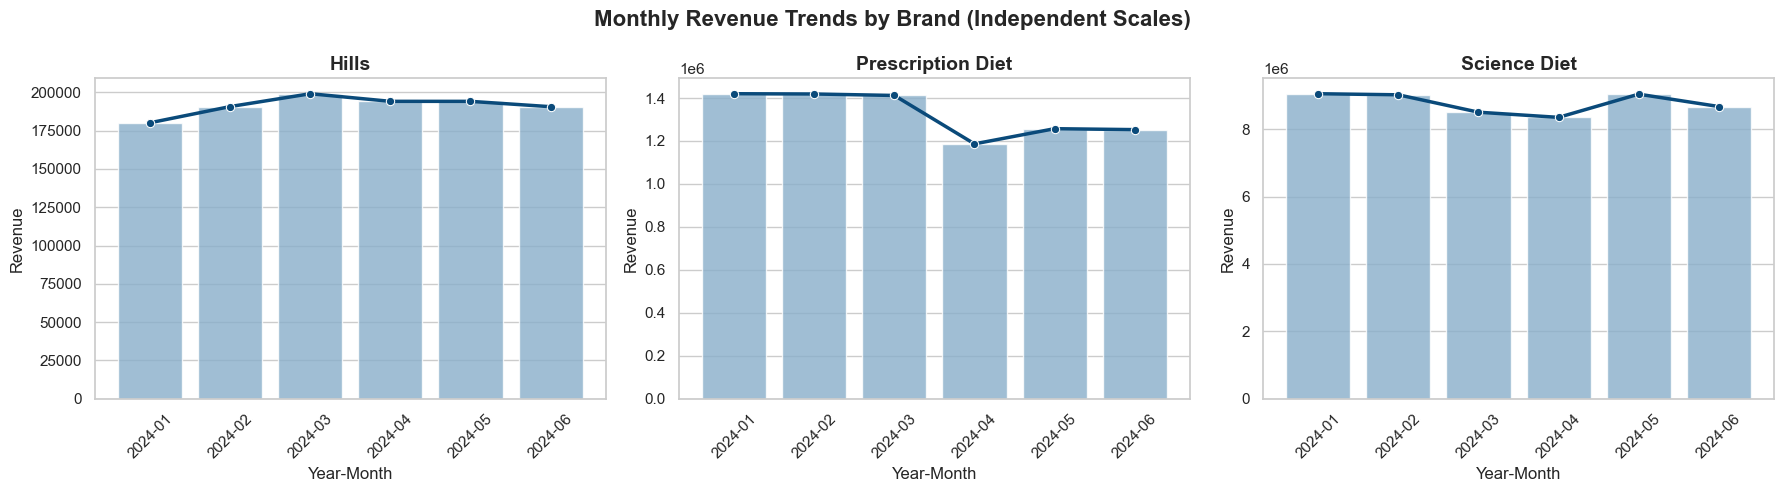

In [14]:
sns.set_theme(style="whitegrid")

# Ensure date column is datetime
df_retailer['date'] = pd.to_datetime(df_retailer['date'], errors='coerce')

# Keep only valid sales
df_sales = df_retailer[df_retailer['sales'].notna()].copy()

# Create year-month column
df_sales['year_month'] = df_sales['date'].dt.to_period('M').astype(str)

# Monthly revenue per brand
monthly_revenue = (
    df_sales.groupby(['year_month', 'brand'])['sales']
    .sum()
    .reset_index()
)

# Brands
brands = monthly_revenue['brand'].unique()

# Side-by-side subplots with independent y-scales
fig, axes = plt.subplots(1, len(brands), figsize=(6 * len(brands), 5), sharey=False)

# Handle single brand case
if len(brands) == 1:
    axes = [axes]

# Plot each brand separately
for ax, b in zip(axes, brands):
    brand_data = monthly_revenue[monthly_revenue['brand'] == b]

    # Barplot
    sns.barplot(
        data=brand_data,
        x='year_month',
        y='sales',
        color="#7EB0D5",
        alpha=0.8,
        ax=ax
    )

    # Lineplot
    sns.lineplot(
        data=brand_data,
        x='year_month',
        y='sales',
        color="#0A4A7A",
        marker='o',
        linewidth=2.5,
        ax=ax
    )

    ax.set_title(b, fontsize=14, weight="bold")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Revenue")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Monthly Revenue Trends by Brand (Independent Scales)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


Science Diet has the highest monthly revenue, followed by Prescription Diet, while Hills remains at a much lower level. Using independent scales highlights brand-specific trends: Hills slightly increases then stabilizes, Prescription Diet declines around March–April before partially recovering, and Science Diet shows moderate variability with a rebound in May.


In [15]:
# Pivot table by brand instead of product_name
brand_stats = df_retailer.pivot_table(
    index='brand',
    columns='event_name',
    values='customer_id',
    aggfunc='count'
)

# Replace NaN with zeros
brand_stats = brand_stats.fillna(0)

# Funnel metrics
brand_stats['cart_rate'] = brand_stats['Add to cart'] / brand_stats['Product Page View']
brand_stats['order_rate'] = brand_stats['Order'] / brand_stats['Product Page View']
brand_stats['conversion_cart_to_order'] = brand_stats['Order'] / brand_stats['Add to cart']

# Top 20 brands by order rate
brand_stats.sort_values('order_rate', ascending=False)


event_name,Add to cart,Order,Product Page View,cart_rate,order_rate,conversion_cart_to_order
brand,,,,,,
Hills,137429,112298,233026,0.589758,0.481912,0.817135
Science Diet,1652119,1201422,5004995,0.330094,0.240045,0.727201
Prescription Diet,236211,116815,894494,0.264072,0.130593,0.494537


Hills shows the highest cart, order, and cart-to-order conversion rates.  
Science Diet generates the largest volumes but lower conversion rates.  
Prescription Diet records the lowest performance across all funnel stages.

#### <span style="color:#1f77b4"><b> Frequency Analysis</b></span> 

This section analyzes customer activity through event frequencies.  
First, we examine the **frequency of events at the customer level**, then extend the analysis **by brand**.  
Finally, we study the **distribution of customers according to their interaction and purchase frequencies**.


In [16]:
# Clean dataset by removing rows with 'unknown' customer_id
df_retailer = df_retailer[df_retailer['customer_id'] != 'unknown']

In [17]:
# Compute the total number of events per customer
customer_event_freq = (
    df_retailer
    .groupby('customer_id')
    .size()
    .reset_index(name='n_events')
)
customer_event_freq.head()

,customer_id,n_events
0,re0007V8sqIHsZnbvC,2
1,re000JYhnKbTkPqMB4,3
2,re000fIO9QXTWYjOfn,23
3,re000kbtVVzPwZcEr4,19
4,re000pHbVOysCXRHgt,17


In [18]:
# Compute the number of purchase events (Order) per customer
customer_order_freq = (
    df_retailer[df_retailer['event_name'] == 'Order']
    .groupby('customer_id')
    .size()
    .reset_index(name='n_orders')
)
customer_order_freq.head()

,customer_id,n_orders
0,re000fIO9QXTWYjOfn,8
1,re000pHbVOysCXRHgt,5
2,re002BI64EJvXZLhyr,3
3,re002SPjzXcRe2XY9F,2
4,re002l1aOJG3OoCTK8,3


In [19]:
# Merge total events and purchase counts at the customer level
customer_freq = customer_event_freq.merge(
    customer_order_freq,
    on='customer_id',
    how='left'
)

customer_freq['n_orders'] = customer_freq['n_orders'].fillna(0).astype(int)
customer_freq.head()

,customer_id,n_events,n_orders
0,re0007V8sqIHsZnbvC,2,0
1,re000JYhnKbTkPqMB4,3,0
2,re000fIO9QXTWYjOfn,23,8
3,re000kbtVVzPwZcEr4,19,0
4,re000pHbVOysCXRHgt,17,5


In [31]:
# Version simple sans .style (qui plante)
summary_table = (
    customer_freq[['n_events', 'n_orders']]
    .describe()
    .round(2)
)

# On affiche simplement le tableau standard
print("Customer-Level Frequency Summary Statistics")
display(summary_table)

Customer-Level Frequency Summary Statistics


,n_events,n_orders
count,1354583.00,1354583.00
mean,7.14,1.04
std,13.94,3.03
min,1.00,0.00
25%,1.00,0.00
50%,3.00,0.00
75%,8.00,1.00
max,6190.00,2013.00


The table shows how active customers are in terms of events and purchases.  
Half of the customers generated **3 events or fewer** and **did not place any order**.  
About **75% of customers** recorded **at most 8 events** and **no more than one purchase**.  
A small number of customers are very active, which explains the large difference between typical values and the maximum values.


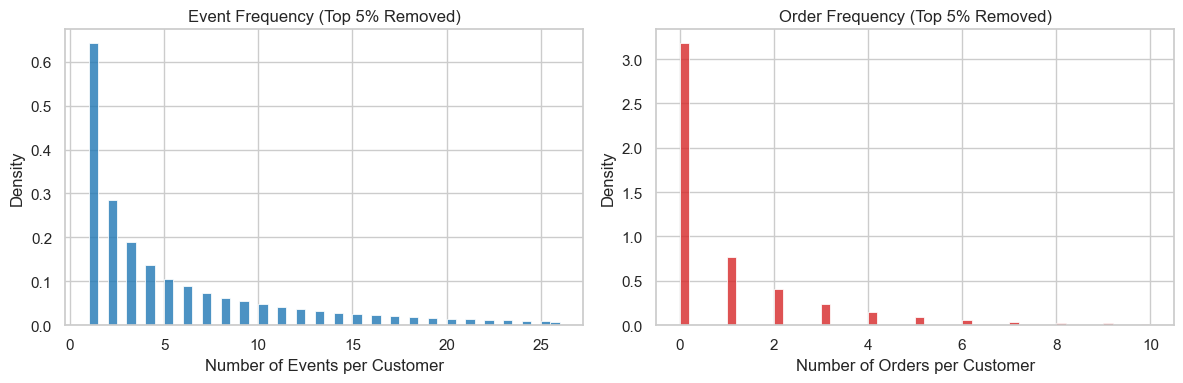

In [20]:
# Distribution of Customer Event and Order Frequencies (Top 5% Removed)

sns.set_theme(style="whitegrid")

# Compute 95th percentiles
p95_events = customer_freq['n_events'].quantile(0.95)
p95_orders = customer_freq['n_orders'].quantile(0.99)

# Truncate top 5%
events_95 = customer_freq[customer_freq['n_events'] <= p95_events]
orders_95 = customer_freq[customer_freq['n_orders'] <= p95_orders]

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# --- Event frequency ---
sns.histplot(
    events_95['n_events'],
    bins=50,
    stat="density",
    color="#1f77b4",
    edgecolor="white",
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("Event Frequency (Top 5% Removed)")
axes[0].set_xlabel("Number of Events per Customer")
axes[0].set_ylabel("Density")

# --- Order frequency ---
sns.histplot(
    orders_95['n_orders'],
    bins=50,
    stat="density",
    color="#d62728",
    edgecolor="white",
    alpha=0.8,
    ax=axes[1]
)
axes[1].set_title("Order Frequency (Top 5% Removed)")
axes[1].set_xlabel("Number of Orders per Customer")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()


The distributions show that customer activity is highly concentrated.  
Most customers generate a small number of events, while a limited fraction accounts for higher activity levels.  
Similarly, the order distribution indicates that the majority of customers place few or no orders, with purchase activity concentrated among a small group of clients.  
Removing the top 5% of customers improves readability and highlights the behavior of the majority.

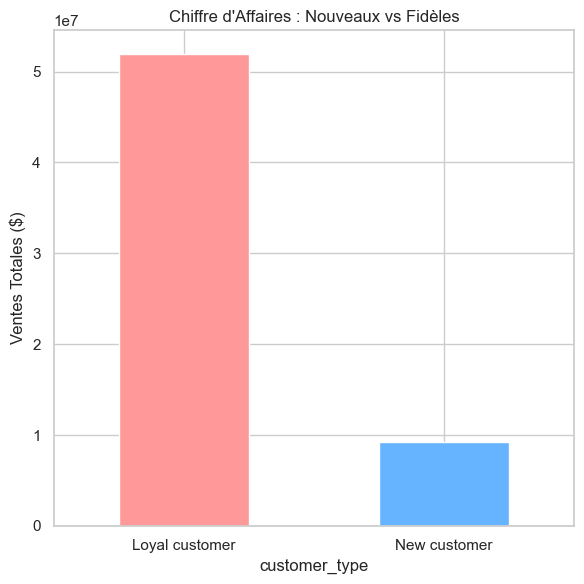

In [22]:
# ==============================================================================
# IMPACT BUSINESS DE LA FIDÉLITÉ (New vs Loyal)
# ==============================================================================

df_orders = df_retailer[df_retailer['event_name'] == 'Order'].copy()
orders_count = df_orders.groupby('customer_id').size()

customer_type = orders_count.apply(
    lambda x: 'New customer' if x == 1 else 'Loyal customer'
)

if 'customer_type' not in df_orders.columns:
    df_orders = df_orders.merge(
        customer_type.rename('customer_type'),
        on='customer_id',
        how='left'
    )

turnover_by_type = df_orders.groupby('customer_type')['sales'].sum()

plt.figure(figsize=(6, 6))
turnover_by_type.plot(kind='bar', color=['#ff9999', '#66b3ff'])
plt.title('Chiffre d\'Affaires : Nouveaux vs Fidèles')
plt.ylabel('Ventes Totales ($)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

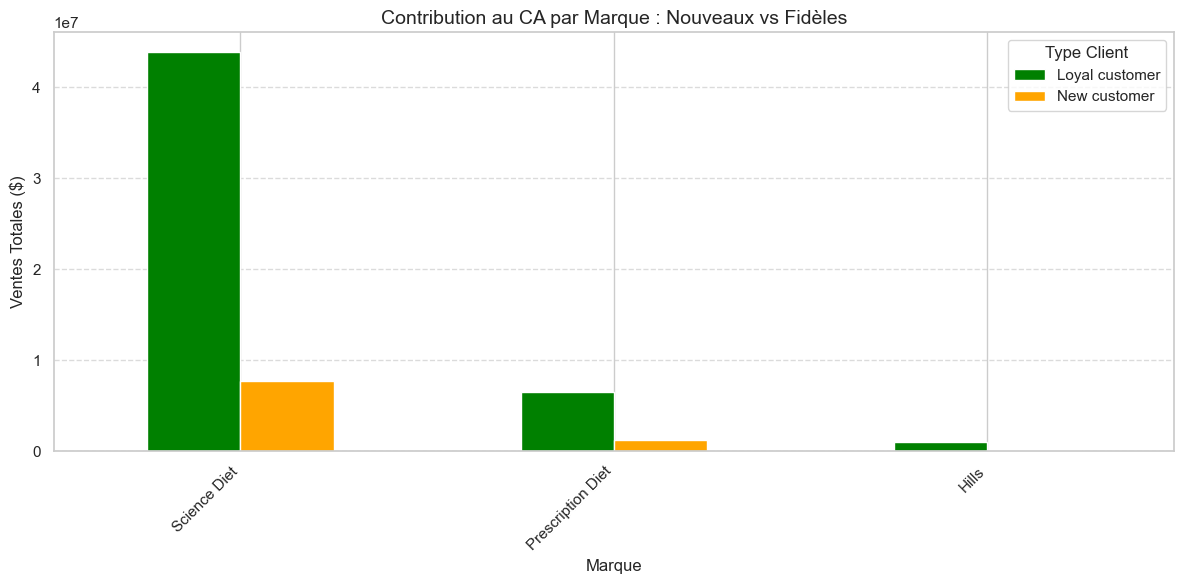

In [23]:
turnover_by_brand_type = df_orders.groupby(['brand', 'customer_type'])['sales'].sum().unstack()

top_brands = df_orders.groupby('brand')['sales'].sum().sort_values(ascending=False).index
turnover_by_brand_type = turnover_by_brand_type.reindex(top_brands)

plt.figure(figsize=(12, 6))
turnover_by_brand_type.plot(kind='bar', color=['green', 'orange'], figsize=(12, 6))

plt.title('Contribution au CA par Marque : Nouveaux vs Fidèles', fontsize=14)
plt.ylabel('Ventes Totales ($)')
plt.xlabel('Marque')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Type Client')
plt.tight_layout()
plt.show()

#### <span style="color:#1f77b4"><b> Clients Segmentation </b></span> 

In [24]:
# Revenue Contribution by Top Customers (1%, 5%, 10%, 20%)
# Total revenue over the period
df_rfm = (
    df_retailer[df_retailer['event_name'] == 'Order']
    .groupby('customer_id')
    .agg(
        monetary=('sales', 'sum')
    )
    .reset_index()
)
total_revenue = df_sales['sales'].sum()

# Percentiles to analyze
percentiles = [0.01, 0.05, 0.10, 0.20]

# Compute revenue contribution for each percentile
results = []

for p in percentiles:
    top_clients = df_rfm.nlargest(int(len(df_rfm) * p), 'monetary')
    revenue_top = top_clients['monetary'].sum()
    pct_revenue = (revenue_top / total_revenue) * 100

    results.append({
        "Top % Clients": f"{int(p*100)}%",
        "Revenue from Top Clients": revenue_top,
        "Share of Total Revenue (%)": pct_revenue
    })

# Convert to DataFrame
revenue_contribution = pd.DataFrame(results)

revenue_contribution


,Top % Clients,Revenue from Top Clients,Share of Total Revenue (%)
0,1%,5174146.03,8.288188
1,5%,14902402.73,23.871364
2,10%,22720377.85,36.394561
3,20%,33388918.66,53.483927


##### RFM Analysis

In [25]:
df_retailer = df_retailer[df_retailer['customer_id'] != 'unknown']
df_orders = df_retailer[df_retailer['event_name'] == 'Order'].copy()

In [26]:
df_orders['timestamp_utc'] = pd.to_datetime(df_orders['timestamp_utc']) 
now = df_orders['timestamp_utc'].max() + dt.timedelta(days=1)

df_orders['days_since'] = (now - df_orders['timestamp_utc']).dt.days

df_rfm = df_orders.groupby('customer_id').agg({
    'days_since': 'min',        
    'sales': 'sum',
    'quantity': 'sum'
}).reset_index()

df_rfm.rename(columns={'days_since': 'Recency', 'sales': 'Monetary'}, inplace=True)

frequency = df_orders.groupby('customer_id')['timestamp_utc'].nunique().reset_index()
frequency.columns = ['customer_id', 'Frequency']

df_rfm = pd.merge(df_rfm, frequency, on='customer_id')

In [27]:
df_rfm['Decile'] = pd.qcut(df_rfm['Monetary'], q=10, labels=False, duplicates='drop')

def definir_segment(row):
    if row['Decile'] == 9:      # Top 10%
        return 'Heavy'
    elif row['Decile'] >= 5:    # Les 40% suivants (Déciles 5, 6, 7, 8)
        return 'Medium'
    else:                       # Les 50% du bas (Déciles 0 à 4)
        return 'Light'

df_rfm['Segment'] = df_rfm.apply(definir_segment, axis=1)

In [28]:
resultats = df_rfm.groupby('Segment').agg({
    'customer_id': 'count',       # Nombre de clients
    'Monetary': 'mean',           # CA moyen par client (Turnover/customer)
    'Frequency': 'mean',          # Fréquence moyenne (Purchase Frequency)
    'Recency': 'mean',            # Récence moyenne
    'quantity': 'sum'             # Somme des articles (pour calcul panier)
}).reindex(['Heavy', 'Medium', 'Light']) # On force l'ordre

# Panier moyen en valeur (Average Price) = CA Moyen / Fréquence Moyenne
resultats['Panier_Moyen'] = resultats['Monetary'] / resultats['Frequency']

# Part du Chiffre d'Affaires Total (% Turnover)
total_ca = df_rfm['Monetary'].sum()
ca_par_segment = df_rfm.groupby('Segment')['Monetary'].sum()
resultats['%_CA_Total'] = (ca_par_segment / total_ca) * 100

print(resultats[['customer_id', '%_CA_Total', 'Monetary', 'Frequency', 'Panier_Moyen']])

         customer_id  %_CA_Total    Monetary  Frequency  Panier_Moyen
Segment                                                              
Heavy          50202   37.128756  452.579137   8.225509     55.021415
Medium        200222   45.793727  139.958523   3.167974     44.179196
Light         251601   17.077517   41.535316   1.445157     28.741036


/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2606144306.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Segment', y='Pct_Customers', data=plot_data, palette=colors)
/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2606144306.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Segment', y='Part_CA_Total', data=plot_data, palette=colors)
/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2606144306.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[

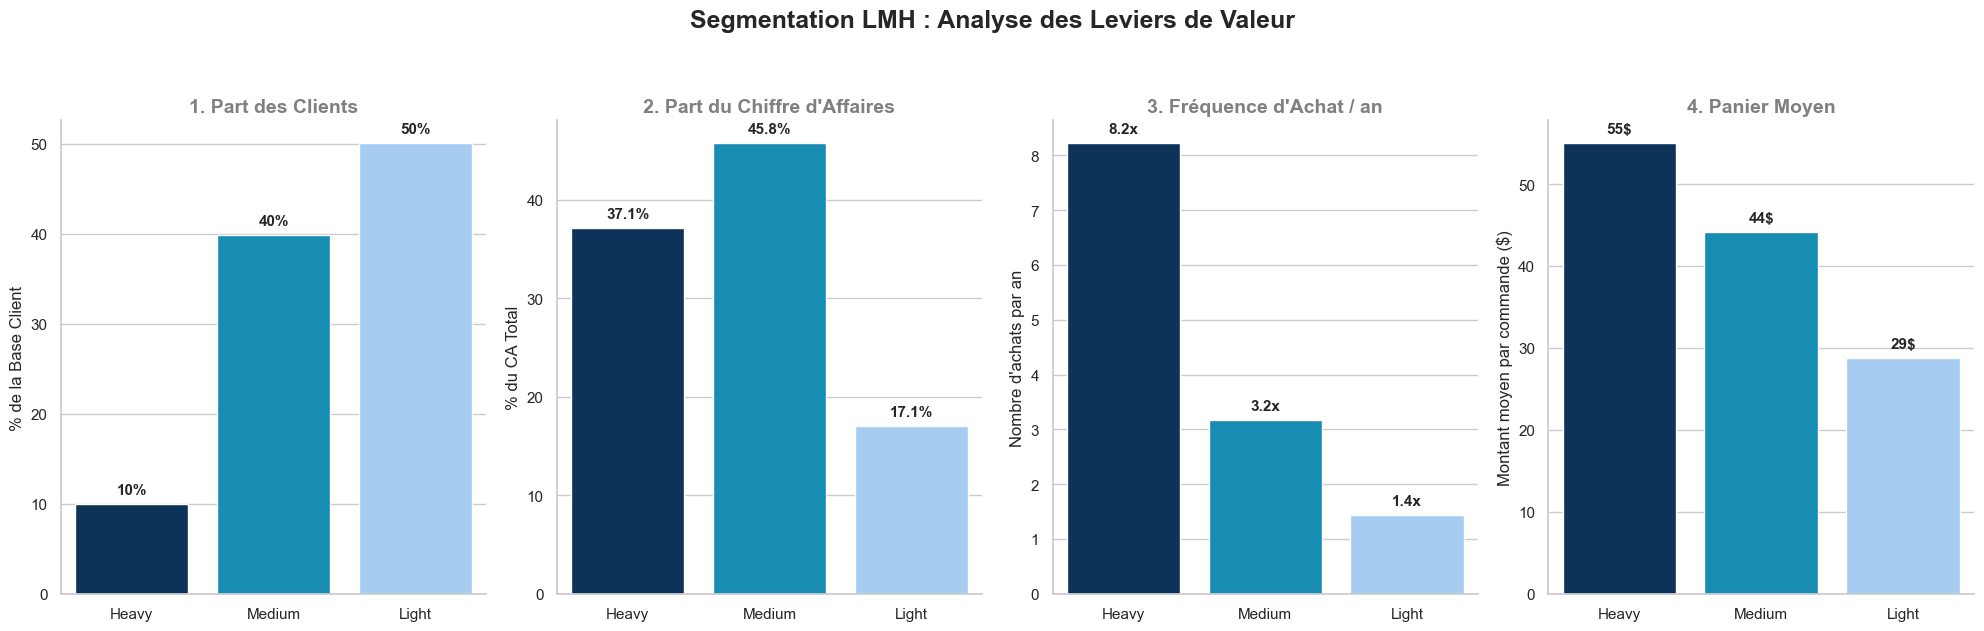

In [29]:
plot_data = resultats.copy().reset_index()

total_customers = plot_data['customer_id'].sum()
plot_data['Pct_Customers'] = (plot_data['customer_id'] / total_customers) * 100

plot_data.rename(columns={
    '%_CA_Total': 'Part_CA_Total', # Le % du Chiffre d'Affaires global
    'Frequency': 'Frequence_Achat', # La fréquence moyenne
    'Panier_Moyen': 'Panier_Moyen' # Le panier moyen
}, inplace=True)

plot_data = plot_data.set_index('Segment').reindex(['Heavy', 'Medium', 'Light']).reset_index()

colors = ['#003366', '#0099cc', '#99ccff'] # Heavy, Medium, Light

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Segmentation LMH : Analyse des Leviers de Valeur', fontsize=18, fontweight='bold', y=1.05)

def add_labels(ax, format_str='{:.1f}'):
    for p in ax.patches:
        valeur = p.get_height()
        txt = format_str.format(valeur)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(txt, (x, y), xytext=(0, 5), textcoords='offset points', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    sns.despine(ax=ax) # Enlever les bords inutiles

# --- GRAPHIQUE 1 : RÉPARTITION DES CLIENTS (%) ---
sns.barplot(ax=axes[0], x='Segment', y='Pct_Customers', data=plot_data, palette=colors)
axes[0].set_title('1. Part des Clients', fontsize=14, fontweight='bold', color='gray')
axes[0].set_ylabel('% de la Base Client')
axes[0].set_xlabel('')
add_labels(axes[0], '{:.0f}%') # Format pourcentage

# --- GRAPHIQUE 2 : RÉPARTITION DU CA (%) ---
sns.barplot(ax=axes[1], x='Segment', y='Part_CA_Total', data=plot_data, palette=colors)
axes[1].set_title('2. Part du Chiffre d\'Affaires', fontsize=14, fontweight='bold', color='gray')
axes[1].set_ylabel('% du CA Total')
axes[1].set_xlabel('')
add_labels(axes[1], '{:.1f}%')

# --- GRAPHIQUE 3 : FRÉQUENCE D'ACHAT (Moyenne) ---
sns.barplot(ax=axes[2], x='Segment', y='Frequence_Achat', data=plot_data, palette=colors)
axes[2].set_title('3. Fréquence d\'Achat / an', fontsize=14, fontweight='bold', color='gray') # Rouge pour souligner l'insight
axes[2].set_ylabel('Nombre d\'achats par an')
axes[2].set_xlabel('')
add_labels(axes[2], '{:.1f}x')

# --- GRAPHIQUE 4 : PANIER MOYEN ($) ---
sns.barplot(ax=axes[3], x='Segment', y='Panier_Moyen', data=plot_data, palette=colors)
axes[3].set_title('4. Panier Moyen', fontsize=14, fontweight='bold', color='gray')
axes[3].set_ylabel('Montant moyen par commande ($)')
axes[3].set_xlabel('')
add_labels(axes[3], '{:.0f}$') 

plt.tight_layout()
plt.show()

In [ ]:
# Prepare transactional data for RFM analysis (keep only purchase events)
#df_rfm_base = (
    #df_retailer[df_retailer['event_name'] == 'Order']
    #.copy()
#)

# Define reference date (last date in the dataset)
#reference_date = df_rfm_base['date'].max() + pd.Timedelta(days=1)

# Compute RFM metrics at customer level
#df_rfm = (
    #df_rfm_base.groupby('customer_id').agg(recency=('date', lambda x: (reference_date - x.max()).days), frequency=('date', 'count'), monetary=('sales', 'sum')).reset_index())
#df_rfm.head()

#df_rfm['R_score'] = pd.qcut(df_rfm['recency'].rank(method='first'),5,labels=[5, 4, 3, 2, 1]).astype(int)

#df_rfm['F_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'),5,labels=[1, 2, 3, 4, 5]).astype(int)

#df_rfm['M_score'] = pd.qcut(df_rfm['monetary'].rank(method='first'),5,labels=[1, 2, 3, 4, 5]).astype(int)

# Compute overall RFM score
#df_rfm['RFM_score'] = (
    #df_rfm['R_score'].astype(str) +
    #df_rfm['F_score'].astype(str) +
    #df_rfm['M_score'].astype(str)
#)

#df_rfm.head()

# Optional: Create simple RFM segments
#df_rfm['segment'] = 'Other'

#df_rfm.loc[df_rfm['RFM_score'].isin(['555','554','545','544','455']), 'segment'] = 'Champions'
#df_rfm.loc[df_rfm['RFM_score'].isin(['543','444','435','434','355']), 'segment'] = 'Loyal Customers'
#df_rfm.loc[df_rfm['RFM_score'].isin(['533','532','531','522']), 'segment'] = 'Potential Loyalists'
#df_rfm.loc[df_rfm['RFM_score'].isin(['311','312','221']), 'segment'] = 'At Risk'
#df_rfm.loc[df_rfm['RFM_score'].isin(['111','112','121']), 'segment'] = 'Lost'

#df_rfm['segment'].value_counts()

# Summary statistics by RFM segment
#rfm_segment_summary = (
    #df_rfm
    #.groupby('segment').agg(n_customers=('customer_id', 'count'),avg_recency=('recency', 'mean'),avg_frequency=('frequency', 'mean'),avg_monetary=('monetary', 'mean')).round(2))

#rfm_segment_summary

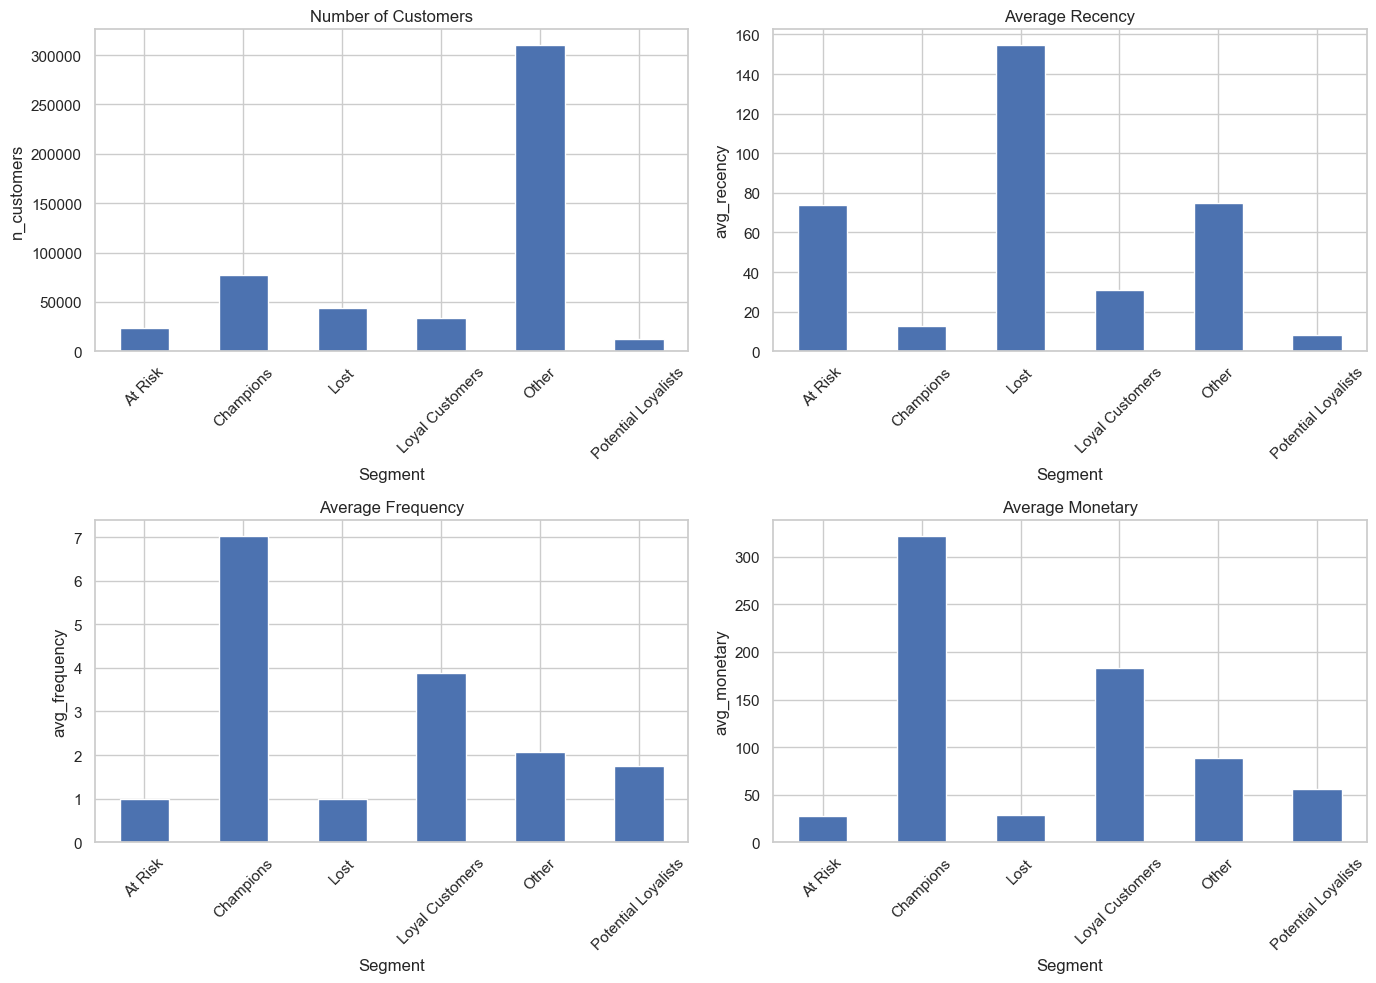

In [ ]:
#fig, axes = plt.subplots(2, 2, figsize=(14, 10))
#axes = axes.flatten()

#cols = [
    #('n_customers', 'Number of Customers'),
    #('avg_recency', 'Average Recency'),
    #('avg_frequency', 'Average Frequency'),
    #('avg_monetary', 'Average Monetary')]

#for ax, (col, title) in zip(axes, cols):
    #rfm_segment_summary[col].plot(
        #kind='bar',
        #ax=ax)
    #ax.set_title(title)
    #ax.set_xlabel('Segment')
    #ax.set_ylabel(col)
    #ax.tick_params(axis='x', rotation=45)

#plt.tight_layout()
#plt.show()

### <span style="color:#1f77b4"><b>Socio_demo Dataset: Data Cleaning and Descriptive Statistics </b></span> 

In [30]:
df_socio = pd.read_csv('data/socio_demo.csv')
df_socio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354584 entries, 0 to 1354583
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1354584 non-null  object
 1   breed        1354584 non-null  object
 2   age          1354584 non-null  object
 3   income       1354584 non-null  object
dtypes: object(4)
memory usage: 41.3+ MB


In [42]:
df_socio.head()

,customer_id,breed,age,income
0,rezLh5Hae3m6flaxM4,Purebred,[25-35[,[120-200K$[
1,resWkHpEcL1IUfdoBp,Purebred,[25-35[,[80-120K$[
2,re9qxF7kS9R2LwOVVY,Purebred,[35-45[,[80-120K$[
3,re3IZNYZY6xr8OAE56,Purebred,[55-65[,[40-80K$[
4,re01lnV2DfgMLdfIF7,Purebred,[65+[,[80-120K$[


In [ ]:
for col in df_socio.columns:
    print(f"\n📌 Unique values in '{col}':")
    print(df_socio[col].unique())


📌 Unique values in 'customer_id':
['rezLh5Hae3m6flaxM4' 'resWkHpEcL1IUfdoBp' 're9qxF7kS9R2LwOVVY' ...
 'reHJlTYbsdyhpQPXzg' 're0dRkGLDObofTjJNj' 'reAwDA5MSjXhPteWq2']

📌 Unique values in 'breed':
['Purebred' 'Mixed-breed']

📌 Unique values in 'age':
['[25-35[' '[35-45[' '[55-65[' '[65+[' '[18-25[' '[45-55[']

📌 Unique values in 'income':
['[120-200K$[' '[80-120K$[' '[40-80K$[' '[200K$+[' '[0-40K$[']


/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2416246289.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2416246289.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/z4/l1g2ltz55419x6y847ly0r800000gn/T/ipykernel_12468/2416246289.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


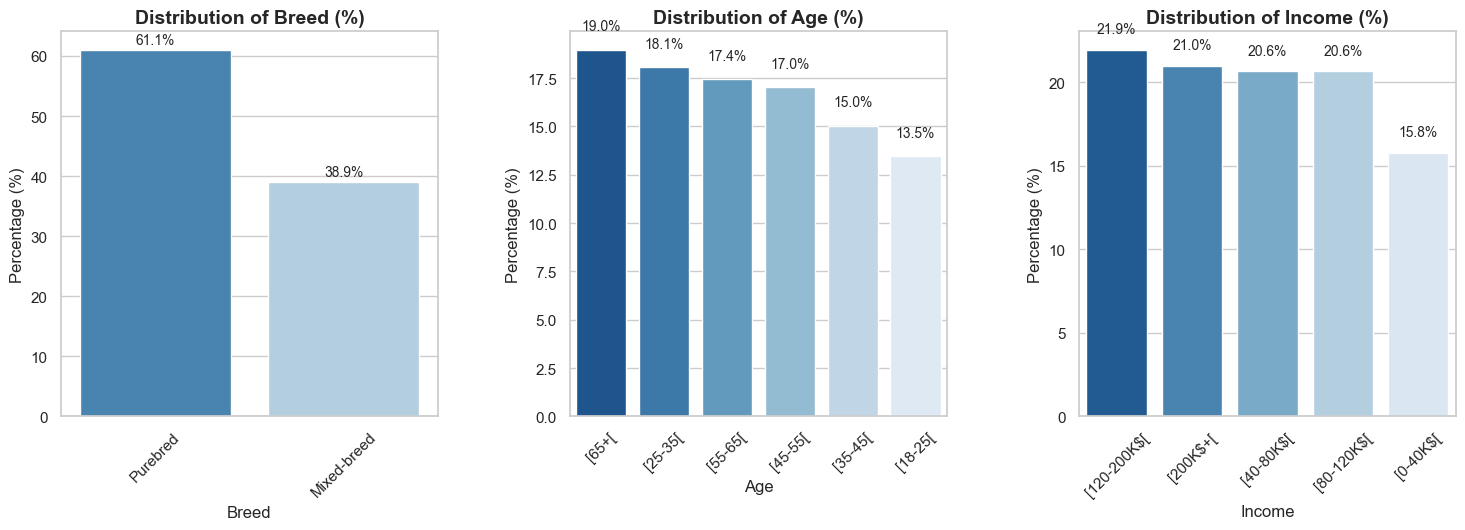

In [31]:
sns.set_theme(style="whitegrid")

# Select all columns except customer_id
cols = [col for col in df_socio.columns if col != "customer_id"]

fig, axes = plt.subplots(1, len(cols), figsize=(6 * len(cols), 5))
plt.subplots_adjust(wspace=0.35)

if len(cols) == 1:
    axes = [axes]

for ax, col in zip(axes, cols):
    
    # Compute percentage distribution
    pct = (
        df_socio[col]
        .value_counts(normalize=True) * 100
    )
    
    # Plot barplot
    sns.barplot(
        x=pct.index,
        y=pct.values,
        palette="Blues_r",
        ax=ax
    )
    
    ax.set_title(f"Distribution of {col.capitalize()} (%)", fontsize=14, weight="bold")
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add % labels above bars
    for i, v in enumerate(pct.values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.show()


The socio-demographic distributions show that **purebred owners are the majority**, accounting for around 60% of the sample. The **age profile is relatively balanced**, with a slight concentration among older customers (65+) and middle-age groups, while younger customers (18–25) are less represented. In terms of income, the distribution is fairly even across brackets, with a modest overrepresentation of higher-income households, indicating a customer base that is broadly diversified but slightly skewed toward higher purchasing power.


In [32]:
df_full = df_retailer.merge(df_socio, on='customer_id', how='left')

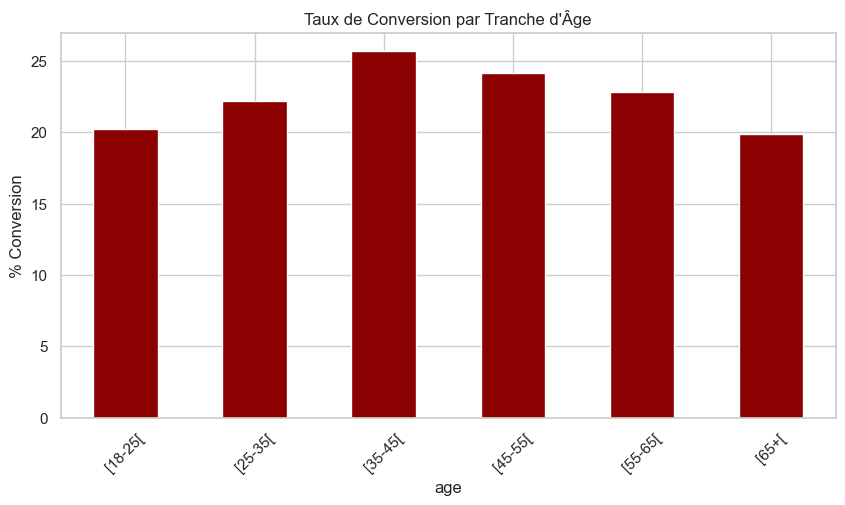

In [33]:
# A. Taux de Conversion par Age
# On calcule View -> Order par tranche d'âge
stats_age = df_full.groupby('age')['event_name'].value_counts().unstack().fillna(0)
if 'Order' in stats_age.columns and 'Product Page View' in stats_age.columns:
    stats_age['Conversion_Rate'] = (stats_age['Order'] / stats_age['Product Page View']) * 100
    
    plt.figure(figsize=(10, 5))
    stats_age['Conversion_Rate'].plot(kind='bar', color='darkred')
    plt.title("Taux de Conversion par Tranche d'Âge")
    plt.ylabel("% Conversion")
    plt.xticks(rotation=45)
    plt.show()